In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# Generating the Dataset

In [2]:
# y_i = 2 * sin(x_i) + x_i^{0.8}
def f(x):
    return 2 * torch.sin(x) + x**0.8

In [3]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)
x_train

tensor([0.0342, 0.1082, 0.2751, 0.2861, 0.3407, 0.3606, 0.3721, 0.4311, 0.4657,
        0.6327, 0.8267, 0.8772, 1.4112, 1.4491, 1.5269, 1.6725, 1.7936, 1.8267,
        1.8477, 1.8489, 1.8647, 1.9420, 2.2784, 2.5829, 2.5905, 2.6089, 2.7840,
        2.9177, 3.0542, 3.1142, 3.2104, 3.3381, 3.4110, 3.4239, 3.4855, 3.5582,
        3.5953, 3.9581, 4.0064, 4.0827, 4.2062, 4.2782, 4.3308, 4.4851, 4.5010,
        4.6001, 4.6562, 4.7293, 4.7400, 4.8924])

In [4]:
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

# Average Pooling

In [5]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
            xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

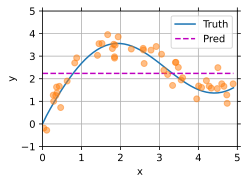

In [6]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

# Nonparametric Attention Pooling

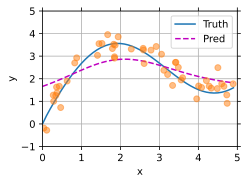

In [7]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# Each element of `y_hat` is weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

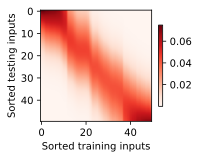

In [8]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                 xlabel='Sorted training inputs', 
                 ylabel='Sorted testing inputs')

# Parametric Attention Pooling

In [9]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [10]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
print(weights.unsqueeze(1).shape)
print(values.unsqueeze(-1).shape)
bmm = torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))
bmm, bmm.shape

torch.Size([2, 1, 10])
torch.Size([2, 10, 1])


(tensor([[[ 4.5000]],
 
         [[14.5000]]]),
 torch.Size([2, 1, 1]))

In [11]:
class NWKernelGegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
        
    def forward(self, queries, keys, values):
        # Shape of the output `queries` and `attention_weights`:
        # (no. of queries, no. of key-value pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 /2, dim=1
        )
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                        values.unsqueeze(-1)).reshape(-1)

In [12]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_title = x_train.repeat((n_train, 1))
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_title = y_train.repeat((n_train, 1))
# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = X_title[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = Y_title[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

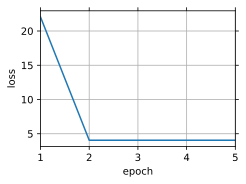

In [13]:
net = NWKernelGegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

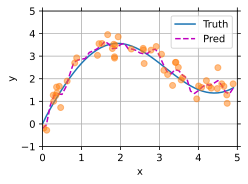

In [14]:
# Shape of `keys`: (`n_test`, `n_train`), where each column contains the same
# training inputs (i.e., same keys)
keys = x_train.repeat((n_test, 1))
# Shape of `value`: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

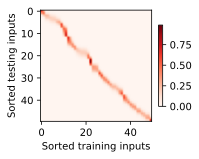

In [15]:
d2l.show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs',
    ylabel='Sorted testing inputs'
)